In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)

In [2]:
df = pd.read_csv("../../our_analyses/dataset_prepared.csv")

In [3]:
from sklearn.preprocessing import LabelEncoder

df=df.drop(['name', 'artists', 'album_name'], axis=1)

genre_groups = {
    'idm': 0, 'iranian': 0, 'study': 0,  # Electronic/Dance
    'black-metal': 1, 'breakbeat': 1, 'techno': 1,  # Metal/Rock
    'brazil': 2, 'forro': 2, 'happy': 2, 'spanish': 2, 'j-idol': 2,  # Country/Folk/Pop
    'afrobeat': 3, 'chicago-house': 3, 'industrial': 3, 'j-dance': 3,  # World/Commercial Pop
    'bluegrass': 4, 'disney': 4, 'indian': 4, 'mandopop': 4, 'sleep': 4  # Other
}


genre_labels = ['Metal and Related', 'Metal/Rock', 'Country/Folk', 'Pop/Commercial', 'World', 'Ambient/New Age', 'Other', 'Indian']


# Mappatura dei generi del dataframe ai gruppi di generi
df['genre_group'] = df['genre'].map(genre_groups).astype(int)

# Stampa del mapping dei generi ai numeri corrispondenti
print(df['genre_group'].unique())

le = LabelEncoder()
df['explicit'] = le.fit_transform(df['explicit'])

[3 1 4 2 0]


## Data cleaning

In [4]:
from sklearn.model_selection import train_test_split

attributes = [col for col in df.columns if col != 'genre_group']
# Definizione di y come l'array delle etichette dei generi
y = np.array(df['genre_group'])

# Rimozione delle colonne 'genre_group' e 'genre' per ottenere le feature
X = df.drop(['genre_group', 'genre', 'mode', 'key', 'time_signature'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # we use 70% and 30% and we stratisfy to have the same distribution for the classes between them in the training and in the test set

In [5]:
from sklearn.preprocessing import StandardScaler

norm = StandardScaler()
norm.fit(X_train)

X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

In [6]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [7]:
from sklearn.model_selection import GridSearchCV

# Configura una nuova ricerca grid con parametri aggiuntivi o intervalli estesi
param_grid = {
    'max_depth': [None] + list(np.arange(5, 20)),
    'min_samples_split': [2, 5, 10, 20, 40],
    'min_samples_leaf': [1, 4, 10, 20, 40],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2'],
    'min_impurity_decrease': [0, 0.1, 0.01, 0.001, 0.0001],
    'splitter': ["best", "random"]
}

# Esegui la ricerca grid
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_norm, y_train)

# Valuta il miglior modello trovato sulla ricerca grid
best_tree = grid_search.best_estimator_
print(f'Migliori parametri trovati: {grid_search.best_params_}')
print(f'Punteggio del miglior modello: {grid_search.best_score_}')

# Prova ensemble learning con Random Forest
from sklearn.ensemble import RandomForestClassifier

# Configura e addestra il RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
rf_clf.fit(X_train_norm, y_train)

# Valuta il RandomForestClassifier
rf_train_acc = rf_clf.score(X_train_norm, y_train)
rf_test_acc = rf_clf.score(X_test_norm, y_test)
print(f'Random Forest train accuracy: {rf_train_acc}')
print(f'Random Forest test accuracy: {rf_test_acc}')

Fitting 5 folds for each of 24000 candidates, totalling 120000 fits
Migliori parametri trovati: {'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Punteggio del miglior modello: 0.6150476190476191
Random Forest train accuracy: 1.0
Random Forest test accuracy: 0.6884444444444444


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Configura una nuova ricerca grid con i parametri ottimali trovati precedentemente
optimal_params = {
    'criterion': ['entropy'],
    'max_depth': [9],
    'max_features': [None],
    'min_impurity_decrease': [0.001],
    'min_samples_leaf': [10],
    'min_samples_split': [2],
    'splitter': ['best']
}

# Aggiungi ccp_alpha alla griglia di parametri
ccp_alpha_params = {
    'ccp_alpha': np.linspace(0, 0.02, 50)  # Definisci un intervallo ragionevole per ccp_alpha
}

# Combinazione dei parametri ottimali con i valori ccp_alpha
optimal_params.update(ccp_alpha_params)

# Esegui la ricerca grid con la nuova gamma di parametri
grid_search_ccp_alpha = GridSearchCV(DecisionTreeClassifier(), optimal_params, cv=5, n_jobs=-1, verbose=1)
grid_search_ccp_alpha.fit(X_train_norm, y_train)

# Stampa i migliori parametri inclusi ccp_alpha
print(f'Migliori parametri con ccp_alpha trovati: {grid_search_ccp_alpha.best_params_}')
print(f'Punteggio del miglior modello con ccp_alpha: {grid_search_ccp_alpha.best_score_}')


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Migliori parametri con ccp_alpha trovati: {'ccp_alpha': 0.0, 'criterion': 'entropy', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'best'}
Punteggio del miglior modello con ccp_alpha: 0.6150476190476191


# Costruzione efficace di un albero decisionale

## Prevenire l'overfitting:

- **Scegli il miglior punto di divisione** basato su misure come l'indice di Gini o l'entropia.
- **Pre-potatura**: Interrompi la crescita dell'albero precocemente seguendo criteri come l'omogeneità delle istanze.
- **Post-potatura**: Semplifica un albero completamente sviluppato usando stime dell'errore di generalizzazione.
- **Gestione degli attributi**: Gestisci attributi continui e categorici in modo appropriato.
- **Convalida incrociata**: Applica metodi come la convalida incrociata per stimare errori di generalizzazione.

## Parametri `best_params_well`:

| Parametro                | Descrizione                                            |
|--------------------------|--------------------------------------------------------|
| `criterion: 'entropy'`   | Misura usata per la qualità di una divisione.          |
| `max_depth: 10`          | Profondità massima dell'albero.                        |
| `max_features: None`     | Numero di funzionalità da considerare per il miglior taglio. |
| `min_impurity_decrease`  | Soglia per la riduzione dell'impurità.                 |
| `min_samples_leaf: 4`    | Numero minimo di campioni richiesti per essere una foglia.  |
| `min_samples_split: 40`  | Numero minimo di campioni richiesti per dividere un nodo interno. |
| `splitter: 'best'`       | Strategia utilizzata per scegliere la divisione a ogni nodo. |
| `ccp_alpha`              | Parametro per la potatura basata sui costi di complessità.    |

## Tecniche di pre-pruning:

- `max_depth`: Limita la profondità massima dell'albero.
- `min_samples_split`: Stabilisce il numero minimo di campioni che un nodo deve avere prima di poter essere diviso.
- `min_samples_leaf`: Definisce il numero minimo di campioni che una foglia deve avere.
- `min_impurity_decrease`: Un nodo sarà diviso solo se questa divisione induce una diminuzione dell'impurità maggiore di questo valore.

## Tecnica di post-pruning:

- `ccp_alpha`: Parametro per la potatura basata sui costi di complessità, usato per rimuovere le parti dell'albero che forniscono poco potere predittivo a fronte di una complessità maggiore.

**Nota**: Gli attributi come `criterion` e `splitter` sono parametri generali per la costruzione dell'albero e non sono specifici delle tecniche di pre-pruning o post-pruning.


In [9]:
# I tuoi iperparametri ottimizzati

# Istanzia il modello con i migliori iperparametri
dt = DecisionTreeClassifier(**optimal_params)
dt.fit(X_train, y_train)

rf_train_acc = dt.score(X_train_norm, y_train)
rf_test_acc = dt.score(X_test_norm, y_test)
print(f'Random Forest train accuracy: {rf_train_acc}')
print(f'Random Forest test accuracy: {rf_test_acc}')

InvalidParameterError: The 'ccp_alpha' parameter of DecisionTreeClassifier must be a float in the range [0.0, inf). Got array([0.        , 0.00040816, 0.00081633, 0.00122449, 0.00163265,
       0.00204082, 0.00244898, 0.00285714, 0.00326531, 0.00367347,
       0.00408163, 0.0044898 , 0.00489796, 0.00530612, 0.00571429,
       0.00612245, 0.00653061, 0.00693878, 0.00734694, 0.0077551 ,
       0.00816327, 0.00857143, 0.00897959, 0.00938776, 0.00979592,
       0.01020408, 0.01061224, 0.01102041, 0.01142857, 0.01183673,
       0.0122449 , 0.01265306, 0.01306122, 0.01346939, 0.01387755,
       0.01428571, 0.01469388, 0.01510204, 0.0155102 , 0.01591837,
       0.01632653, 0.01673469, 0.01714286, 0.01755102, 0.01795918,
       0.01836735, 0.01877551, 0.01918367, 0.01959184, 0.02      ]) instead.

In [ ]:
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [ ]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 1.0
Train F1-score [1. 1. 1. 1. 1.]

Test Accuracy 0.578
Test F1-score [0.62331839 0.54117647 0.5734327  0.49060899 0.64575972]


In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.63      0.62      0.62       675
           1       0.54      0.55      0.54       675
           2       0.57      0.58      0.57      1125
           3       0.50      0.48      0.49       900
           4       0.64      0.65      0.65      1125

    accuracy                           0.58      4500
   macro avg       0.58      0.57      0.57      4500
weighted avg       0.58      0.58      0.58      4500



In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [ ]:
zipped = zip(attributes, dt.feature_importances_)
zipped = sorted(zipped, key=lambda x: x[1], reverse=True)
for col, imp in zipped:
    print(col, imp)

speechiness 0.1273824309237377
popularity 0.1222337855789319
energy 0.11890963102679036
mode 0.09038347642796343
instrumentalness 0.08917688464471267
danceability 0.08701716099278141
key 0.07120817429018514
liveness 0.06998194972726735
duration_ms 0.06442269387489383
loudness 0.06383519563141023
acousticness 0.051069028833309354
valence 0.03813918211664322
explicit 0.0062404059313735105


#### Decision Tree hyperparameters

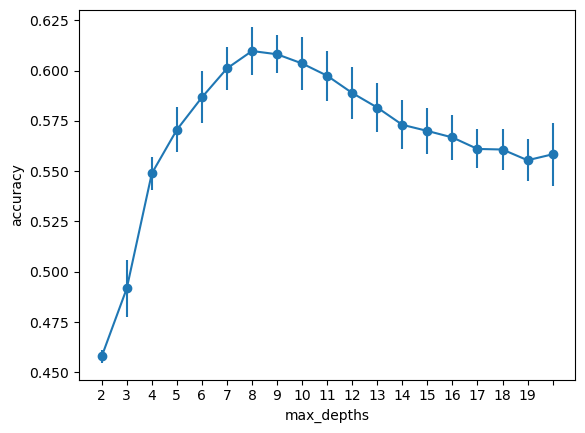

In [ ]:
from sklearn.model_selection import cross_val_score

max_depths =  list(np.arange(2, 20)) + [None]
avg_scores = list()
std_scores = list()

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(max_depths)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(max_depths)), max_depths)
plt.xlabel("max_depths")
plt.ylabel("accuracy")
plt.show()

In [ ]:
min_samples_splits = [0.002, 0.01, 0.05, 0.1, 0.2]
avg_scores = list()
std_scores = list()

for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_splits)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_splits)), min_samples_splits)
plt.xlabel("min_samples_split") 
plt.ylabel("accuracy")
plt.show()

KeyboardInterrupt: 

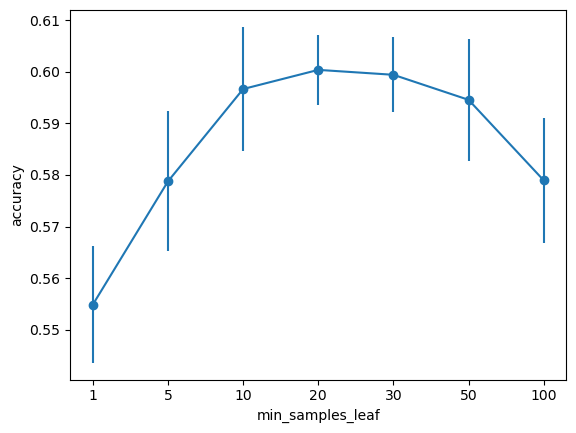

In [ ]:
min_samples_leafs = [1, 5, 10, 20, 30, 50, 100]
avg_scores = list()
std_scores = list()

for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    scores = cross_val_score(dt, X_train, y_train, cv=5)
    avg_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))

plt.errorbar(range(len(min_samples_leafs)), y=avg_scores, yerr=std_scores, marker='o')
plt.xticks(range(len(min_samples_leafs)), min_samples_leafs)
plt.xlabel("min_samples_leaf")
plt.ylabel("accuracy")
plt.show()

### Randomized search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

Test Accuracy: 0.6093333333333333
Test F1 Score: 0.6089233825482003


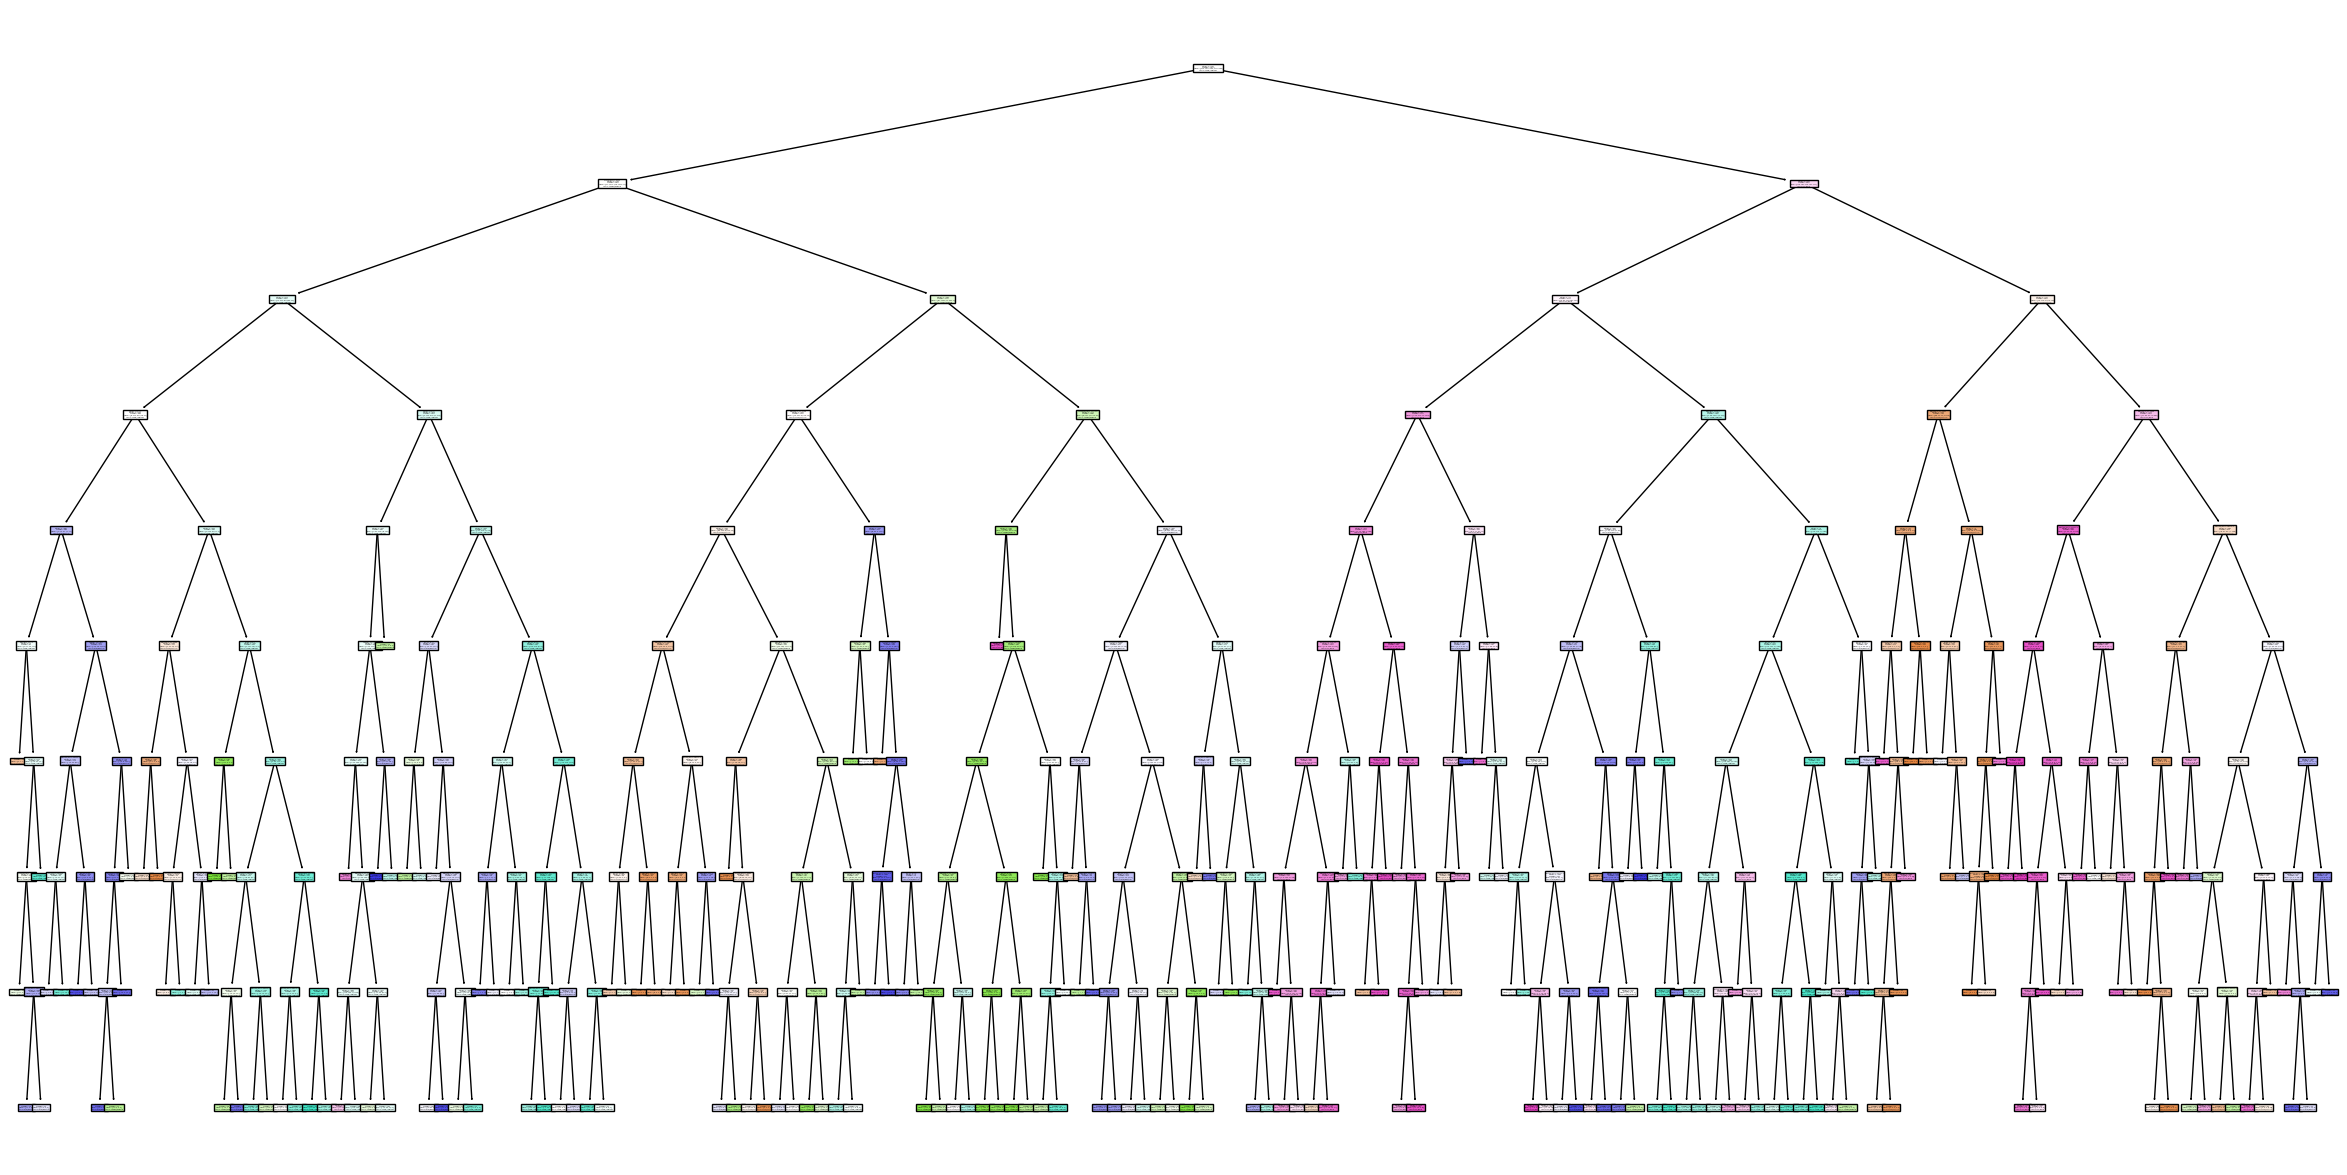

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# I tuoi iperparametri ottimizzati
# best_params = {'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 4, 'min_samples_split': 40}


# Istanzia il modello con i migliori iperparametri
dt_optimized = DecisionTreeClassifier(**grid_search.best_params_)

# Addestra il modello
dt_optimized.fit(X_train, y_train)

# Effettua previsioni sul set di test
y_test_pred_optimized = dt_optimized.predict(X_test)
y_train_pred_optimized = dt_optimized.predict(X_train)

# Valuta il modello
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1_score = f1_score(y_test, y_test_pred, average='weighted') # 'weighted' tiene conto del bilanciamento delle classi

print(f'Test Accuracy: {test_accuracy}')
print(f'Test F1 Score: {test_f1_score}')

# Se desideri visualizzare l'albero decisionale
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(30,15))
plot_tree(dt_optimized, feature_names=attributes, class_names=genre_labels, filled=True)
plt.show()


In [ ]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dt_optimized.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()


In [ ]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred_optimized))
print('Train F1-score %s' % f1_score(y_train, y_train_pred_optimized, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred_optimized))
print('Test F1-score %s' % f1_score(y_test, y_test_pred_optimized, average=None))

Train Accuracy 0.6827619047619048
Train F1-score [0.75633406 0.64936793 0.66606563 0.6041979  0.73461612]

Test Accuracy 0.6093333333333333
Test F1-score [0.67214339 0.54446178 0.61641541 0.49325843 0.69470828]


In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix

# Assumiamo che 'y_test' e 'y_test_pred' siano già definiti e contengano le etichette vere e predette dal tuo modello

# Genera la matrice di confusione
cf = confusion_matrix(y_test, y_test_pred_optimized)

# Definisci le etichette per i generi in base ai raggruppamenti definiti
genre_labels = ['Dance/Electronic', 'Ambient/Relaxing', 'Global/Traditional', 'Metal/Industrial', 'Pop/World']

# Crea la heatmap usando plotly
fig = ff.create_annotated_heatmap(z=cf, x=genre_labels, y=genre_labels,
                                  annotation_text=cf.astype(str), colorscale='Greens')

# Aggiorna il layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5,
                  xaxis=dict(title='Predicted Labels', tickangle=45),
                  yaxis=dict(title='True Labels', tickmode='array', tickvals=list(range(len(genre_labels))), ticktext=genre_labels),
                  yaxis_autorange='reversed')  # Reverse the y-axis to have the first class at the top

# Mostra il grafico
fig.show()


In [ ]:
path = dt_optimized.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [ ]:

# Esegui la cross-validation per ogni valore di ccp_alpha e raccogli i punteggi di accuratezza
cv_scores = []
for ccp_alpha in ccp_alphas:
    dt_cv = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    scores = cross_val_score(dt_cv, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

# Trova il valore di ccp_alpha che massimizza l'accuratezza media della cross-validation
best_ccp_alpha_index = np.argmax(cv_scores)
best_ccp_alpha = ccp_alphas[best_ccp_alpha_index]

# Stampa dei risultati per ccp_alpha
print(f"Best ccp_alpha: {best_ccp_alpha} with cross-validated accuracy: {cv_scores[best_ccp_alpha_index]}")

Best ccp_alpha: 0.0010126067491228533 with cross-validated accuracy: 0.6060952380952381


In [ ]:
for alpha, imp in zip(ccp_alphas, impurities):
    print(alpha, imp)

0.0 1.1201694882453894
0.0010126067491228533 1.1211820949945124
0.001022911654544087 1.1222050066490565
0.0010289731261192668 1.1232339797751758
0.001037905773426709 1.1242718855486025
0.0010415553402242156 1.1253134408888268
0.00104230887887315 1.1263557497677
0.0010519411007254074 1.1274076908684254
0.001053144523563955 1.1284608353919894
0.0010547141153154256 1.1295155495073048
0.0010591441650644965 1.1305746936723693
0.0010634789017589692 1.1316381725741282
0.0010656308218813873 1.1327038033960097
0.00107494039670979 1.1337787437927196
0.0010872755752000807 1.1348660193679196
0.00110209626749892 1.1359681156354187
0.0011201269581515363 1.1370882425935702
0.001122225163539743 1.1393326929206498
0.0011362626413499504 1.1404689555619998
0.0011576157866049937 1.1416265713486047
0.0011613189195618335 1.1439492091877284
0.0011644163950355934 1.1451136255827639
0.0011880853351333154 1.1463017109178972
0.001193543569912978 1.1474952544878103
0.001194660551072539 1.148689915038883
0.0011954

Impurità Totale vs Alpha Efficace: Questo grafico illustra l'impurità totale delle foglie dell'albero al variare del parametro ccp_alpha. Con valori bassi di alpha, l'albero è complesso con bassa impurità. Man mano che alpha aumenta, le impurità aumentano perché l'albero si semplifica, eliminando divisioni che contribuiscono poco alla riduzione dell'impurità.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

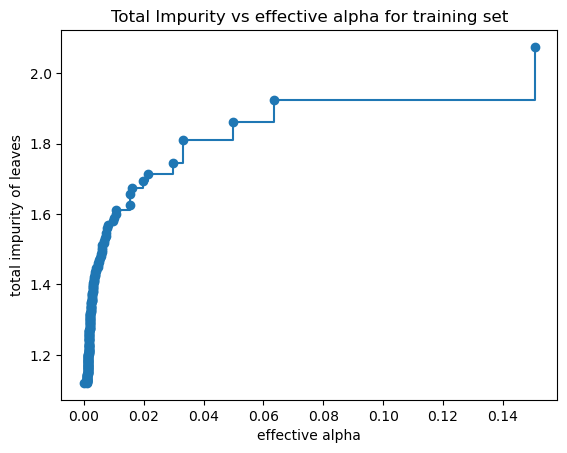

In [ ]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [ ]:
random_search.best_params_

NameError: name 'random_search' is not defined

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha, **random_search.best_params_)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.19308170520078827


Numero di Nodi vs Alpha: Dimostra come il numero di nodi nell'albero diminuisce significativamente all'aumentare di alpha. Un numero ridotto di nodi implica un modello più semplice ma possibilmente meno adatto a catturare le sottigliezze dei dati.

Profondità vs Alpha: Mostra la profondità dell'albero in relazione a diversi valori di alpha. Più è alto il valore di alpha, più l'albero viene potato, risultando in una profondità minore e potenzialmente una maggiore generalizzazione.

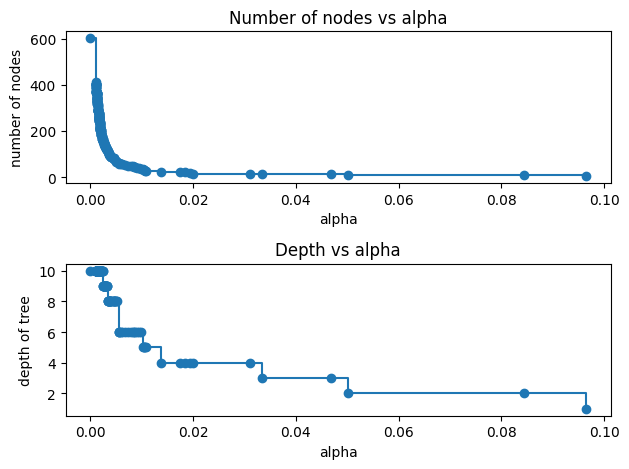

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Accuratezza vs Alpha per Set di Addestramento e Test: Questo grafico confronta l'accuratezza sui set di addestramento e test. Un buon valore di alpha è colui che mantiene alta l'accuratezza sui dati di addestramento mentre massimizza l'accuratezza sui dati di test. La scelta di alpha si basa su un compromesso tra prestazioni e complessità, cercando un punto in cui l'accuratezza si stabilizza prima di diminuire drasticamente, indicando un buon equilibrio tra adattamento e generalizzazione.

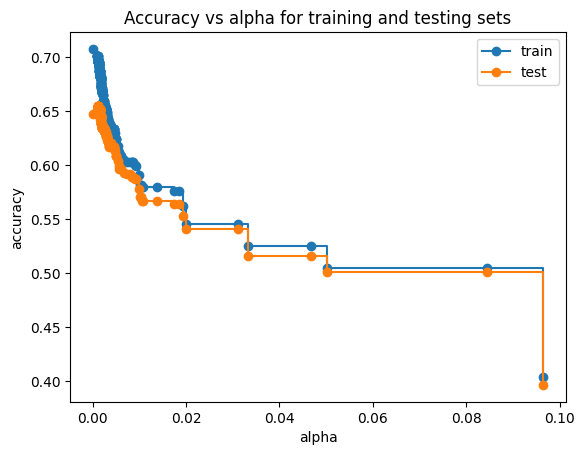

In [ ]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Per scegliere il ccp_alpha, considereremmo il grafico "Accuracy vs Alpha per i set di addestramento e test". Sceglieremmo un valore di alpha che massimizza l'accuratezza sui dati di test mantenendo ancora buone prestazioni sui dati di addestramento. Il punto ideale sarebbe appena prima che l'accuratezza sul test inizi a diminuire o dove l'accuratezza di test si stabilizza. Questo ci indica che il modello è abbastanza generalizzato per gestire nuovi dati ma non troppo semplificato da perdere l'accuratezza predittiva. Analizzando i grafici forniti, potremmo considerare un valore di alpha intorno a 0.01, dove sembra esserci un equilibrio tra complessità e accuratezza. Tuttavia, questa è solo una stima visiva; per una scelta definitiva, potremmo voler analizzare ulteriormente i risultati o eseguire validazioni aggiuntive.

In [ ]:
best_params_well = {'criterion': 'gini', 'max_depth': 9, 'max_features': None, 'min_impurity_decrease': 0, 'min_samples_leaf': 10, 'min_samples_split': 40, 'splitter': 'best'}
dtp = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01, **best_params_well)
dtp.fit(X_train, y_train)

y_test_pred = dtp.predict(X_test)
y_train_pred = dtp.predict(X_train)

In [ ]:
print('Train Accuracy %s' % accuracy_score(y_train, y_train_pred))
print('Train F1-score %s' % f1_score(y_train, y_train_pred, average=None))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_test_pred))
print('Test F1-score %s' % f1_score(y_test, y_test_pred, average=None))

Train Accuracy 0.6983809523809524
Train F1-score [0.71825032 0.71655329 0.77548525 0.65277778 0.50280435]

Test Accuracy 0.6482222222222223
Test F1-score [0.67459643 0.64812576 0.72688017 0.58823529 0.47845468]


In [ ]:
y_test_pred = dtp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_test_pred))

Accuracy: 0.6482222222222223


In [ ]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.65      0.71      0.67      1125
           1       0.71      0.60      0.65       900
           2       0.71      0.75      0.73      1350
           3       0.61      0.57      0.59       450
           4       0.48      0.48      0.48       675

    accuracy                           0.65      4500
   macro avg       0.63      0.62      0.62      4500
weighted avg       0.65      0.65      0.65      4500



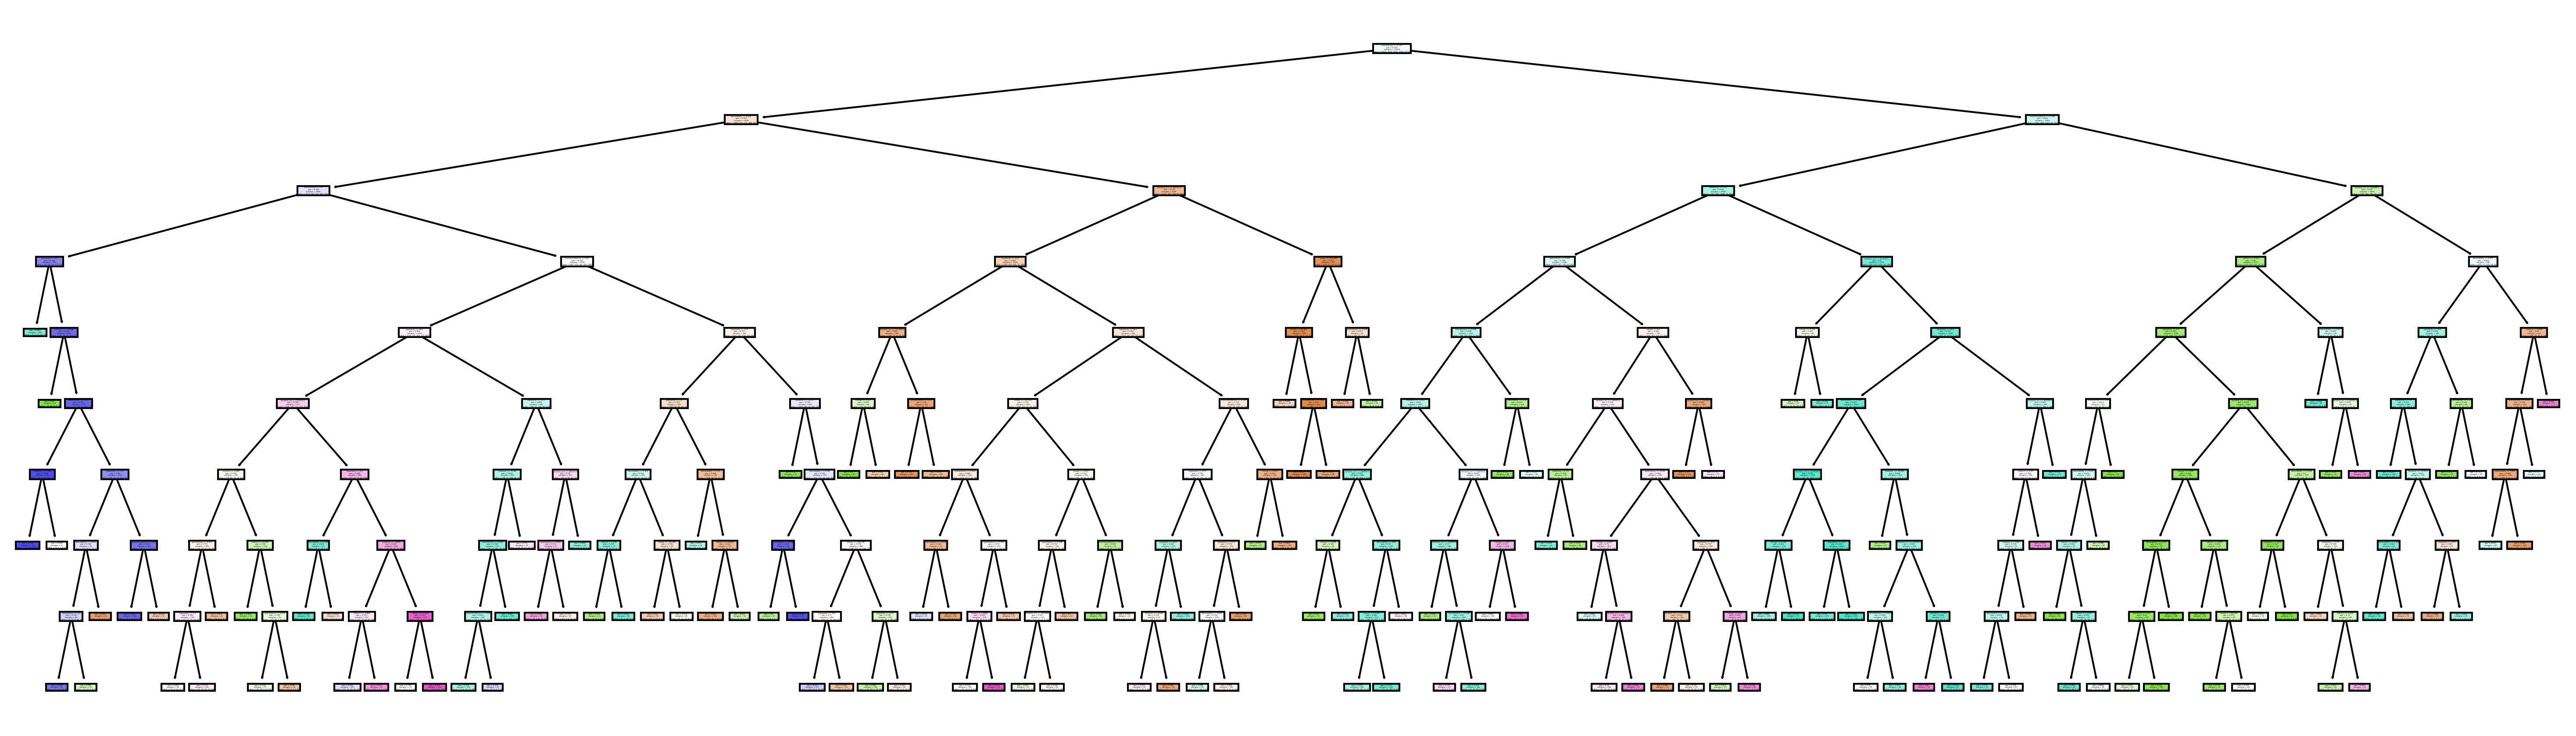

In [ ]:
plt.figure(figsize=(25, 7), dpi=300)
plot_tree(dtp, feature_names=attributes, filled=True)
plt.show()

In [ ]:
import plotly.graph_objs as go
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

# Assicurati che Z_train, Z_test, t_train, e t_test siano definiti e che i tuoi dati siano già preelaborati
# Z_train, Z_test, t_train, t_test = ...

# Previsione delle probabilità per il set di test
y_score = dtp.predict_proba(X_test)

# Binarizza il vettore delle etichette in un formato "one-vs-all"
y_test_binarize = label_binarize(y_test, classes=np.unique(y_train))

# Calcola ROC curve e AUC per ciascuna classe
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_score.shape[1]

# Preparare i dati per il plot
traces = []

# Calcola la ROC curve per ogni classe
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    traces.append(go.Scatter(x=fpr[i], y=tpr[i], mode='lines', 
                             name=f'Class {i} (AUC = {roc_auc[i]:.2f})'))

# Aggiungi la linea diagonale che rappresenta il caso di "indovinare casualmente"
traces.append(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Chance', 
                         line=dict(dash='dash')))

# Crea il layout del plot
layout = go.Layout(title='Multiclass ROC Curve',
                   xaxis=dict(title='False Positive Rate'),
                   yaxis=dict(title='True Positive Rate'),
                   width=1000,
                   height=800,
                   showlegend=True,
                   legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

fig = go.Figure(data=traces, layout=layout)
fig.show()
